In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

In [156]:
# Get data
data = pd.read_csv('../resources/data/data_fred_2020-05.csv')
print("Original data shape: ", data.shape)

# Get transformations
transformations = data.iloc[0][1:]
data = data.drop(axis=0, index=0)

# Set date as index of df
data['sasdate'] = pd.to_datetime(data['sasdate'])
data.set_index('sasdate', inplace=True)

# Select only data from 1960-01-01 untill 2019-12-01
data = data.loc[(data.index >= '1960-01-01') & (data.index <= '2019-12-01')]

data.head()

Original data shape:  (737, 129)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,2543.148,2394.0,17.987,303096.9723,18763.67069,24.8958,25.3866,24.0030,34.7849,25.1624,...,11.710,2.22,2.57,2.13,NaN,286.7,7362.0,14063.0,75.4515,NaN
1960-02-01,2546.061,2396.2,18.065,307496.8191,18833.15808,24.6743,25.2427,23.9206,34.3887,24.8161,...,11.729,2.23,2.59,2.14,100.0,287.0,7396.0,14144.0,73.3363,NaN
1960-03-01,2550.928,2398.4,18.321,299000.1151,18812.41558,24.4528,25.1563,23.8932,34.4284,24.3256,...,11.736,2.24,2.69,2.14,NaN,287.8,7456.0,14239.0,71.5296,NaN
1960-04-01,2559.682,2407.1,18.605,301955.4992,19306.08721,24.2589,25.2139,23.9206,34.6661,24.2967,...,11.761,2.23,2.61,2.14,NaN,288.3,7582.0,14413.0,71.4718,NaN
1960-05-01,2565.840,2413.0,18.229,292566.3236,19017.76638,24.2312,25.3578,24.0854,34.8642,24.5275,...,11.792,2.24,2.64,2.14,93.3,289.1,7673.0,14559.0,71.6858,NaN


In [157]:
# Considering missing values and show highest 10. Only need to drop 5 series
print("MISSING: \n", data.isnull().sum().sort_values(ascending=False).head(6))

# Drop series with more than 10 missing values
to_drop = data.isnull().sum().sort_values(ascending=False).head(5).index
print("Dropping {}".format(to_drop))

# Dropping series from data
data = data.drop(to_drop, axis=1)

# Dropping series from transformations
transformations = transformations.drop(to_drop)

# Check indeed dropped
print("MISSING NEW \n", data.isnull().sum().sort_values(ascending=False).head(6))
data.head()

MISSING: 
 ACOGNO           385
TWEXAFEGSMTHx    156
UMCSENTx         144
ANDENOx           97
VXOCLSx           30
REALLN             0
dtype: int64
Dropping Index(['ACOGNO', 'TWEXAFEGSMTHx', 'UMCSENTx', 'ANDENOx', 'VXOCLSx'], dtype='object')
MISSING NEW 
 RPI        0
EXSZUSx    0
AAAFFM     0
T10YFFM    0
T5YFFM     0
T1YFFM     0
dtype: int64


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,2543.148,2394.0,17.987,303096.9723,18763.67069,24.8958,25.3866,24.0030,34.7849,25.1624,...,57.056,17.903,11.710,2.22,2.57,2.13,286.7,7362.0,14063.0,75.4515
1960-02-01,2546.061,2396.2,18.065,307496.8191,18833.15808,24.6743,25.2427,23.9206,34.3887,24.8161,...,57.149,17.904,11.729,2.23,2.59,2.14,287.0,7396.0,14144.0,73.3363
1960-03-01,2550.928,2398.4,18.321,299000.1151,18812.41558,24.4528,25.1563,23.8932,34.4284,24.3256,...,56.982,17.937,11.736,2.24,2.69,2.14,287.8,7456.0,14239.0,71.5296
1960-04-01,2559.682,2407.1,18.605,301955.4992,19306.08721,24.2589,25.2139,23.9206,34.6661,24.2967,...,57.050,18.050,11.761,2.23,2.61,2.14,288.3,7582.0,14413.0,71.4718
1960-05-01,2565.840,2413.0,18.229,292566.3236,19017.76638,24.2312,25.3578,24.0854,34.8642,24.5275,...,57.044,18.042,11.792,2.24,2.64,2.14,289.1,7673.0,14559.0,71.6858


In [158]:
def transform_series(code, series):
    # Codes correspond the following transformations:
    # 1: No transformation
    # 2: first difference
    # 3: second difference
    # 4: log
    # 5: log first difference
    # 6: log second difference
    # 7: first difference of log ratio
    treshold = 1e-6
    output = series

    if code == 1:
        output = series
    elif code == 2:
        output = series.diff()
    elif code == 3:
        output = series.diff().diff()
    elif code == 4:
        if series.min() > treshold:
            output = np.log(series)
        else:
            print("Did not transform series: ", series.name)
    elif code == 5:
        if series.min() > treshold:
            output = np.log(series).diff()
        else:
            print("Did not transform series: ", series.name)
    elif code == 6:
        if series.min() > treshold:
            output = np.log(series).diff().diff()
        else:
            print("Did not transform series: ", series.name)
    elif code == 7:
        output = series.pct_change().diff()
    else:
        raise ValueError('Transformation code not recognized')
    
    return output

In [159]:
# Transform data
for i, code in enumerate(transformations):
    data.iloc[:, i] = transform_series(code, data.iloc[:, i])

# Drop first 2 row with NaN values
data = data.iloc[2:, :]

In [164]:
# Inspecting data properties
data['INDPRO'].describe()

# Save for inspection
data.to_csv('../resources/data/data_fred_transformed_2020-05.csv')

In sample PCA to compare to the original paper. Paper uses Jan 1960 to Dec 2019

[0.39983949 0.13977607 0.11196975 0.08548435 0.04621788 0.03156906
 0.02362399 0.01617779 0.01322362 0.01102884 0.01073727 0.00778183
 0.00758195 0.00676998 0.00648534]


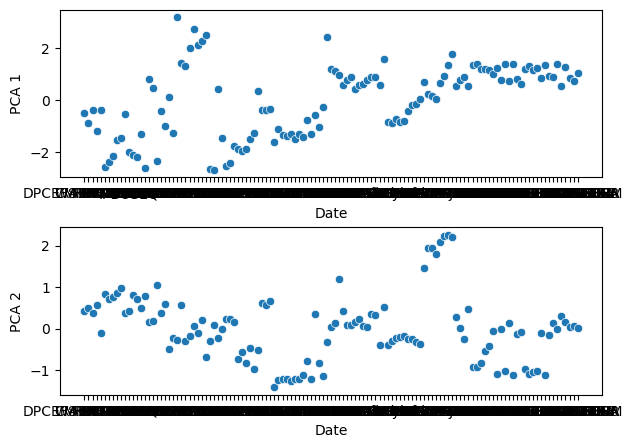

In [162]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a PCA instance: pca
pca = PCA(n_components=15)

data_corr = data.corr()

# Fit the PCA instance to the scaled samples
pca.fit(data_corr)

# Get the explained variances from pca
eigen_values = pca.explained_variance_ratio_

# Eigenvectors are the components
eigen_vectors = pca.components_

print(eigen_values)
# Transform the scaled samples: pca_features
pca_features = pca.transform(data_corr)


plots = 2
fig, ax = plt.subplots(plots,1,figsize=(7,5))
plt.subplots_adjust(hspace=0.3)

for i in range(plots):
    sns.scatterplot(x = data_corr.index, y=pca_features[:,i], ax=ax[i])
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('PCA {}'.format(i+1))


In [163]:
import numpy as np

def pc_T(y, nfac):
    bigt, bign = y.shape

    yy = np.dot(y, y.T)

    eigval, Fhat0 = np.linalg.eigh(yy)
    eigval = eigval[::-1]    # Eigenvalues are in ascending order by default, so reversing them to match Matlab code
    Fhat0 = Fhat0[:, ::-1]   # Eigenvectors are sorted by corresponding eigenvalues, so reversing the order

    fhat = np.dot(Fhat0[:, :nfac], np.sqrt(bigt))

    lambda_ = np.dot(y.T, fhat) / bigt

    ehat = y - np.dot(fhat, lambda_.T)

    ve2 = np.sum(ehat ** 2, axis=1) / bign

    ss = eigval

    return ehat, fhat, lambda_, ve2, ss

# Get the explained variances from pca
_, _, _, _, eigen_values = pc_T(data_corr, data_corr.shape[1])
print(eigen_values/np.sum(eigen_values))

[4.78976037e-01 1.17418745e-01 1.09014812e-01 7.10544286e-02
 4.10152139e-02 2.61393359e-02 2.01064784e-02 1.34522046e-02
 1.13902336e-02 9.19798763e-03 9.02203882e-03 6.45346463e-03
 6.28370354e-03 5.80310338e-03 5.39836601e-03 4.53149386e-03
 4.38367242e-03 4.20938126e-03 3.86038335e-03 3.68902423e-03
 3.39059420e-03 3.25891583e-03 2.67818769e-03 2.55481719e-03
 2.40350136e-03 2.28887591e-03 2.18294623e-03 2.12693015e-03
 1.84435336e-03 1.68376333e-03 1.64203420e-03 1.56893234e-03
 1.37867878e-03 1.29614136e-03 1.23700909e-03 1.14094774e-03
 1.09672615e-03 1.03519518e-03 9.61090146e-04 9.04367468e-04
 8.82033306e-04 8.29766484e-04 7.55586976e-04 7.43167315e-04
 6.68530888e-04 6.31093477e-04 5.98291289e-04 5.64277721e-04
 5.10340133e-04 4.70704363e-04 4.54791799e-04 4.15332127e-04
 3.95750128e-04 3.38462671e-04 3.34412624e-04 3.09862014e-04
 2.82059219e-04 2.69676739e-04 2.36725303e-04 2.09086702e-04
 1.89131259e-04 1.74047586e-04 1.61669927e-04 1.38382671e-04
 1.26278713e-04 1.170416

In [370]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE

def predict_pca(data, h_steps=1, response='CPIAUCSL', test_start='1985-01-01'):
    # Split into train and test sets with train ending at december 1984
    initial_train = data[:test_start]
    initial_test = data[test_start:]

    T_train = initial_train.shape[0]
    T_test = initial_test.shape[0]
    T = data.shape[0]

    # Split into X and y
    X = data
    y = data[response]

    # Shift y by h steps
    y = y.shift(h_steps)

    # Initialize the list of MSE's
    preds = []
    actuals = []


    # t is where the test set start
    for t in range(T_train, T):

        # Split into X and y, dropping first h rows from training data to account for the shift
        X_train, y_train = X[h_steps:t], y[h_steps:t]
        X_test, y_test = X[t:(t + h_steps)], y[t:(t + h_steps)]
        
        # Scale the features by the slope of the regression line
        X_train = scale_X(X_train, y_train)

        # Apply PCA to the features
        pca = PCA(n_components=5)
        pca.fit(X_train)
        
        # Transform the training and test sets
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test.values)

        # Fit the model to the training data
        model = LinearRegression()
        model.fit(X_train_pca, y_train)    

        # Make predictions 1 step ahead
        y_pred = model.predict(X_test_pca)

        # Compute the MSE
        preds.append(y_pred)
        actuals.append(y_test.values)


    return actuals, preds

def scale_X(X_train, y_train):
    X_train = X_train.copy()
    T = X_train.shape[0]

    # Standardize the data
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)

    slopes = []

    for i in range(X_train.shape[1]):
        # Seperate the predictor from the rest of the data
        X_predictor = X_train_standardized[:,i].reshape(-1, 1)

        # Fit the model
        lr = LinearRegression(fit_intercept=True)
        lr.fit(X_predictor, y_train)

        # Obtain the slope coefficient which is the beta
        slope = lr.coef_
        slopes.append(slope)

    scaler_demean = StandardScaler(with_mean=False, with_std=False)
    X_train_demeaned = scaler_demean.fit_transform(X_train)

    for i, slope in enumerate(slopes):
        X_train_demeaned[:,i] = X_train_demeaned[:,i] * slope

    return np.sqrt(T) * X_train_demeaned

def compute_R2(actuals, preds):
    SSR = []
    SST = []
    for i in range(len(actuals)):
        SSR.append(np.sum((actuals[i] - preds[i])**2))
        SST.append(np.sum((actuals[i] - np.mean(actuals[i]))**2))

    SSR = np.sum(SSR)
    SST = np.sum(SST)

    print("SSR: ", SSR, "SST: ", SST)
    R2 = 1 - SSR/SST
    return R2

In [369]:
actual_y, predicted_y = predict_pca(data, 1)

-inf


C:\Users\Vincent\AppData\Local\Temp\ipykernel_8508\2042118580.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1 - np.sum(SSR)/np.sum(SST)


In [371]:
print(compute_R2(actual_y, predicted_y))

SSR:  1930.893431008673 SST:  0.0
-inf


C:\Users\Vincent\AppData\Local\Temp\ipykernel_8508\2607139705.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1 - SSR/SST
